# Urban Sound Tinkering w/ Pickles

## By: Austin Anderson

The purpose of this notebook is to create the pickle files that will contain the 9-1 fold splits. Reading in .wav files, converting to spectrograms, and then running the model for each 9-1 split will take waaaay too long. This notebook also contains some minor exploration of audio at the beginning and some practice with OneHotEncoding towards the bottom.

### Importing Libraries

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import librosa as lr
import librosa.display
from glob import glob
import IPython.display
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM, Dropout, Dense
from keras.layers import Conv2D, AveragePooling2D
from keras.layers import MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Activation
from keras.callbacks import TensorBoard
from keras import regularizers, optimizers
from sklearn.metrics import confusion_matrix,classification_report
from sklearn import preprocessing
import pickle
import os
import seaborn as sns

https://forums.fast.ai/t/deep-learning-with-audio-thread/38123 is super useful!

In [4]:
# Setting directory for wav files

# Using r takes in raw string (no need for // escape)
data_dir = r"D:/Machine_Learning/UrbanSound8K/UrbanSound8K/audio/fold1"

audio_files = glob(data_dir + '/*.wav')

len(audio_files)

873

In [5]:
print(audio_files[11])

D:/Machine_Learning/UrbanSound8K/UrbanSound8K/audio/fold1\103074-7-0-2.wav


In [6]:
audio, sfreq = lr.load(audio_files[55])

time = np.arange(0, len(audio)) / sfreq

time

array([0.00000000e+00, 4.53514739e-05, 9.07029478e-05, ...,
       3.99986395e+00, 3.99990930e+00, 3.99995465e+00])

In [7]:
sfreq

22050

In [8]:
np.shape(audio)

(88200,)

[Text(0, 0.5, 'Sound Amplitude'), Text(0.5, 0, 'Time (s)')]

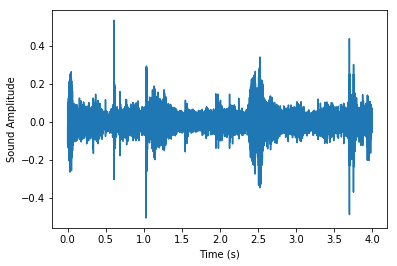

In [9]:
fig, ax = plt.subplots()
ax.plot(time, audio)
ax.set(xlabel='Time (s)', ylabel='Sound Amplitude')

In [10]:
IPython.display.Audio(data=audio, rate=sfreq)

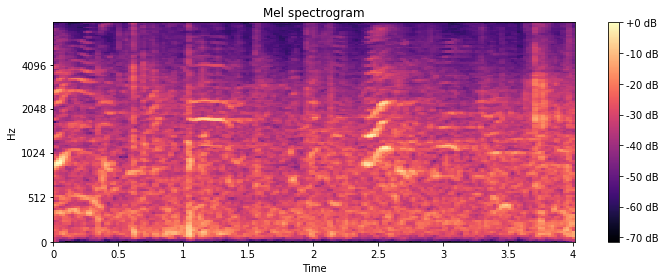

In [11]:
y, sr = lr.load(audio_files[55])
lr.feature.melspectrogram(y=y, sr=sr)
# array([[  2.891e-07,   2.548e-03, ...,   8.116e-09,   5.633e-09],
# [  1.986e-07,   1.162e-02, ...,   9.332e-08,   6.716e-09],
# ...,
# [  3.668e-09,   2.029e-08, ...,   3.208e-09,   2.864e-09],
# [  2.561e-10,   2.096e-09, ...,   7.543e-10,   6.101e-10]])

# Using a pre-computed power spectrogram

D = np.abs(lr.stft(y))**2
S = lr.feature.melspectrogram(S=D)

# Passing through arguments to the Mel filters
S = lr.feature.melspectrogram(y=y, sr=sr, n_mels=128,
                                    fmax=8000)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
lr.display.specshow(lr.power_to_db(S,
                                             ref=np.max),
                         y_axis='mel', fmax=8000,
                         x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

In [12]:
print(np.shape(D))
print(np.shape(S))

(1025, 173)
(128, 173)


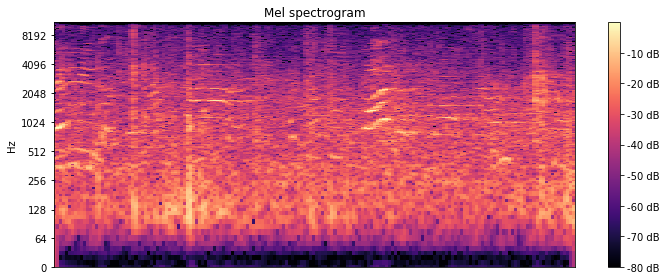

In [21]:
plt.figure(figsize=(10, 4))
lr.display.specshow(lr.power_to_db(D, ref=np.max), y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

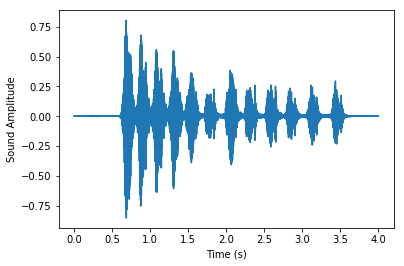

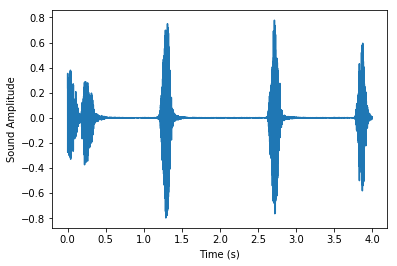

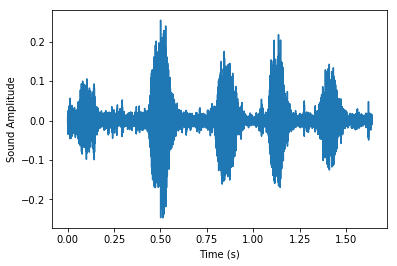

In [22]:
for file in range(1,4):
    audio, sfreq = lr.load(audio_files[file])

    time = np.arange(0, len(audio)) / sfreq
    
    fig, ax = plt.subplots()
    ax.plot(time, audio)
    ax.set(xlabel='Time (s)', ylabel='Sound Amplitude')

In [23]:
metadata = pd.read_csv(r"D:\Machine_Learning\UrbanSound8K\UrbanSound8K\metadata\UrbanSound8K.csv")

metadata.head(5)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [24]:
metadata.set_index('slice_file_name', inplace = True)

### Need to make a classes dataframe for confusion matrix later!

In [25]:
# Selects those two columns
classes = metadata[['classID', 'class']]

# Drops duplicates, then sorts by classID
classes = classes.drop_duplicates(subset=['classID','class']).sort_values('classID')

# Make ClassID the index
classes.set_index('classID', inplace = True)

# Print
classes

,class
classID,
0,air_conditioner
1,car_horn
2,children_playing
3,dog_bark
4,drilling
5,engine_idling
6,gun_shot
7,jackhammer
8,siren


In [26]:
metadata.head(5)

,fsID,start,end,salience,fold,classID,class
slice_file_name,,,,,,,
100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


### Setting configurations

In [27]:
configs = {}

configs['sampling_rate'] = 22050
configs['duration'] = 4
configs['hop_length'] = 882 # 20ms
configs['fmin'] = 20
configs['fmax'] = configs['sampling_rate'] // 2
configs['n_mels'] = 128
configs['n_fft'] = configs['n_mels'] * 20
configs['samples'] = configs['sampling_rate'] * configs['duration']
configs['dims'] = (configs['n_mels'], 1 + int(np.floor(configs['samples']/configs['hop_length'])), 1)

## This prepares the spectrograms before being fed into the model (will be saved to pickle file later)

In [28]:
X_train = []
X_test = []
Y_train = []
Y_test = []
#_min = float('inf')
#_max = -float('inf')

for file in metadata.index:
    filename = 'D:/Machine_Learning/UrbanSound8K/UrbanSound8K/audio/fold'+str(metadata.at[file, 'fold'])+ '/'+file
    audio, sfreq = lr.load(filename)

    # If file is too long, cut it to first 4 seconds
    if len(audio) > configs['samples']:
        audio = audio[0:0+configs['samples']]

    # Else if it is too short, pad with zeroes and then center it
    elif len(audio) < configs['samples']:
        padding = configs['samples'] - len(audio)
        offset = padding // 2
        audio = np.pad(audio, (offset, configs['samples'] - len(audio) - offset), 'constant')

    # Computes melspectogram
    spectrogram = lr.feature.melspectrogram(audio, 
                                                sr=configs['sampling_rate'],
                                                n_mels=configs['n_mels'],
                                                hop_length=configs['hop_length'],
                                                n_fft=configs['n_fft'],
                                                fmin=configs['fmin'],
                                                fmax=configs['fmax'])
    spectrogram = lr.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)

    # Running min and max for mormalization
    #_min = min(np.amin(spectrogram), _min)
    #_max = max(np.amin(spectrogram), _max)
        
    if metadata.at[file, 'fold'] != 10:
        X_train.append(spectrogram)
        Y_train.append(metadata.at[file, 'classID'])
    
    else:
        X_test.append(spectrogram)
        Y_test.append(metadata.at[file, 'classID'])

# Converts the lists into numpy arrays
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = np.array(X_test), np.array(Y_test)

# I DID NOT NORMALIZE
#X = (X - _min) / (_max - _min)

# Reshapes numpy arrays to have 1 channel
# Also One hot encodes the labels
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
Y_train = to_categorical(Y_train, num_classes = 10)

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
Y_test = to_categorical(Y_test, num_classes = 10)

In [143]:
print(np.shape(X_train), "\n", 
      np.shape(X_test))

(7895, 128, 101, 1) 
 (837, 128, 101, 1)


In [35]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=configs['dims']))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.compile(optimizers.rmsprop(lr=0.0005, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 128, 101, 32)      320       
_________________________________________________________________
activation_15 (Activation)   (None, 128, 101, 32)      0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 126, 99, 64)       18496     
_________________________________________________________________
activation_16 (Activation)   (None, 126, 99, 64)       0         
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 63, 49, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 63, 49, 64)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 63, 49, 64)        36928     
__________

In [18]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
model.fit(X_train, Y_train,
          batch_size=32,
          epochs=20,
          verbose=1,
          validation_data=(X_test, Y_test))
          #callbacks=[history])

Train on 7895 samples, validate on 837 samples
Epoch 1/20
7895/7895 [==============================] - 8s 1ms/step - loss: 0.2084 - acc: 0.9373 - val_loss: 1.0529 - val_acc: 0.7670
Epoch 2/20
7895/7895 [==============================] - 8s 1ms/step - loss: 0.2051 - acc: 0.9357 - val_loss: 1.3921 - val_acc: 0.7670
Epoch 3/20
7895/7895 [==============================] - 8s 1ms/step - loss: 0.1968 - acc: 0.9388 - val_loss: 1.1435 - val_acc: 0.7407
Epoch 4/20
7895/7895 [==============================] - 8s 1ms/step - loss: 0.1916 - acc: 0.9443 - val_loss: 1.3570 - val_acc: 0.7192
Epoch 5/20
7895/7895 [==============================] - 8s 1ms/step - loss: 0.1892 - acc: 0.9450 - val_loss: 1.5592 - val_acc: 0.7503
Epoch 6/20
7895/7895 [==============================] - 8s 1ms/step - loss: 0.1842 - acc: 0.9446 - val_loss: 1.2148 - val_acc: 0.7563
Epoch 7/20
7895/7895 [==============================] - 8s 1ms/step - loss: 0.1727 - acc: 0.9497 - val_loss: 1.3016 - val_acc: 0.7336
Epoch 8/20
7895

In [141]:
model.save(r"D:\Machine_Learning\UrbanSound8K\UrbanSound8K\babys_first_model\baby_model.h5")

In [42]:
Y_predict = model.evaluate(X_test, Y_test)
print(Y_predict)


837/837 [==============================] - 0s 350us/step


In [51]:
test_predictions = model.predict(X_test)
print(test_predictions)

[[1.3029405e-08 9.9916899e-01 2.2328024e-07 ... 1.4425690e-04
  2.1712413e-08 8.0337742e-08]
 [4.6911694e-20 9.9999964e-01 4.8413534e-14 ... 3.7503483e-07
  2.1647258e-13 8.5495153e-13]
 [3.5476059e-16 1.0000000e+00 1.5292158e-15 ... 1.2345343e-14
  4.8930612e-15 1.2553832e-13]
 ...
 [1.9543677e-12 9.1956630e-17 1.1691810e-19 ... 4.1157272e-02
  4.1912009e-19 9.2535232e-15]
 [2.0288313e-12 4.2993037e-17 2.0068468e-13 ... 1.9292235e-08
  9.9938168e-17 8.4282407e-11]
 [8.6661789e-12 2.3241423e-17 8.0329585e-21 ... 3.1745039e-05
  2.2724998e-21 7.1808396e-13]]


In [52]:
Y_test

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [54]:
np.argmax(Y_test,axis=1)

array([1, 1, 1, 1, 1, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 3, 3, 9, 9, 9, 9, 9, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 3, 3, 3, 3,
       3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 5, 5, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 4, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 9, 9, 9,

In [53]:
np.argmax(test_predictions,axis=1)

array([1, 1, 1, 1, 1, 3, 3, 3, 3, 2, 2, 3, 2, 2, 2, 2, 2, 3, 3, 5, 7, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 0, 7, 3, 5, 5, 5, 5, 5, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 3, 3, 9, 9, 9, 9, 9, 9, 8, 8, 4, 4, 8, 8, 4, 4, 4,
       4, 4, 4, 4, 0, 9, 9, 0, 5, 5, 5, 0, 0, 0, 0, 5, 5, 5, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 2, 2, 9, 8, 9, 9, 9, 0, 5, 9,
       9, 9, 0, 0, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 3, 2, 4, 9, 9, 2, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 3, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 4, 4, 7, 4, 7,
       7, 7, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 4, 4, 3, 7, 7, 7, 4, 4, 4, 4, 5, 7, 7, 7,
       7, 7, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 9, 9, 9,

In [90]:
# Transforming numbers into labels

# Get list of labels in order
my_list = classes["class"].tolist()

# Using sklearn labelencoder
le = preprocessing.LabelEncoder()
le.fit(my_list)

#Transforming Test matrices
labelled_test = le.inverse_transform(np.argmax(Y_test,axis=1))
labelled_predictions = le.inverse_transform(np.argmax(test_predictions,axis=1))

In [91]:
confusion = confusion_matrix(labelled_test, labelled_predictions)
confusion

array([[61,  0,  2, 11,  8, 10,  0,  5,  3,  0],
       [ 0, 32,  0,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  0, 86, 11,  0,  1,  0,  0,  1,  1],
       [ 0,  0,  0, 90,  3,  1,  1,  1,  0,  4],
       [ 7,  0,  0,  2, 79,  1,  0,  7,  4,  0],
       [ 8,  0,  0,  1,  0, 72,  1,  7,  0,  4],
       [ 0,  0,  0,  0,  0,  0, 32,  0,  0,  0],
       [ 0,  0,  0,  1, 11,  3,  0, 81,  0,  0],
       [ 8,  0, 11, 18,  1,  0,  2,  0, 42,  1],
       [ 3,  0,  4,  0,  2,  1,  0,  0,  1, 89]], dtype=int64)

In [99]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[61  0  2 11  8 10  0  5  3  0]
 [ 0 32  0  0  0  0  0  0  0  1]
 [ 0  0 86 11  0  1  0  0  1  1]
 [ 0  0  0 90  3  1  1  1  0  4]
 [ 7  0  0  2 79  1  0  7  4  0]
 [ 8  0  0  1  0 72  1  7  0  4]
 [ 0  0  0  0  0  0 32  0  0  0]
 [ 0  0  0  1 11  3  0 81  0  0]
 [ 8  0 11 18  1  0  2  0 42  1]
 [ 3  0  4  0  2  1  0  0  1 89]]


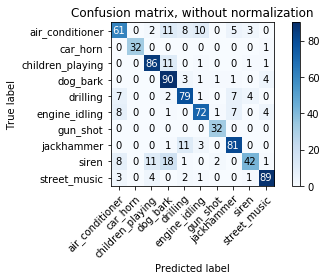

In [103]:
plot_confusion_matrix(labelled_test, labelled_predictions, classes=my_list,
                      title='Confusion matrix, without normalization')

In [95]:
my_list

['air_conditioner',
 'car_horn',
 'children_playing',
 'dog_bark',
 'drilling',
 'engine_idling',
 'gun_shot',
 'jackhammer',
 'siren',
 'street_music']

## This saves the spectograms into a pickle file for one 9-1 fold split!

In [29]:
pickle.dump([X_train, Y_train, X_test, Y_test], open('D:/Machine_Learning/UrbanSound8K/UrbanSound8K/pickles/10_fold_10/10_fold_10.p', 'wb'))

### This is how we load in the pickle file for CV

In [28]:
infile = open('D:/Machine_Learning/UrbanSound8K/UrbanSound8K/pickles/10_fold_10/10_fold_10.p','rb')
list1, list2, list3, list4 = pickle.load(infile)
infile.close()

In [84]:
my_list = classes["class"].tolist()
my_list

['air_conditioner',
 'car_horn',
 'children_playing',
 'dog_bark',
 'drilling',
 'engine_idling',
 'gun_shot',
 'jackhammer',
 'siren',
 'street_music']

# Transfer Learning

For Resnet50, the spectrograms need to be 3-channel. The solution prevalent online was to stack 3 greyscale images in numpy. A better solution would be to modify Resnet to accept single-channel, but that would require more time to figure out.

In [116]:
#np.stack([array]*3, axis=-1)

# Converts single-channel tensor to 3-channel tensor by duplicating image 3 times
X_train_3d = np.squeeze(np.stack((X_train,) * 3, -1))
X_test_3d = np.squeeze(np.stack((X_test,) * 3, -1))

In [117]:
np.shape(X_test_3d)

(837, 128, 101, 3)

In [1]:
from keras.applications.resnet50 import ResNet50

resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128,101,3))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


c:\users\austin\appdata\local\programs\python\python36\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


#### Here is how to replace the top of Resnet50 w/ GAP2D + Dropout

In [122]:
x = resnet_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(10, activation= 'softmax')(x)
final_model = Model(inputs = resnet_model.input, outputs = predictions)

In [123]:
final_model.compile(optimizers.rmsprop(lr=0.0005, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])
final_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 101, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 107, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 51, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 51, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [124]:
final_model.fit(X_train_3d, Y_train,
          batch_size=32,
          epochs=100,
          verbose=1,
          validation_data=(X_test_3d, Y_test))
          #callbacks=[history])

Train on 7895 samples, validate on 837 samples
Epoch 1/100
7895/7895 [==============================] - 34s 4ms/step - loss: 1.2300 - acc: 0.6818 - val_loss: 9.3852 - val_acc: 0.2891
Epoch 2/100
7895/7895 [==============================] - 26s 3ms/step - loss: 0.7741 - acc: 0.8212 - val_loss: 2.6501 - val_acc: 0.6655
Epoch 3/100
7895/7895 [==============================] - 27s 3ms/step - loss: 0.4607 - acc: 0.8866 - val_loss: 3.8057 - val_acc: 0.6452
Epoch 4/100
7895/7895 [==============================] - 27s 3ms/step - loss: 0.4218 - acc: 0.9058 - val_loss: 4.8522 - val_acc: 0.4552
Epoch 5/100
7895/7895 [==============================] - 26s 3ms/step - loss: 0.2871 - acc: 0.9235 - val_loss: 0.7926 - val_acc: 0.7826
Epoch 6/100
7895/7895 [==============================] - 26s 3ms/step - loss: 0.2277 - acc: 0.9401 - val_loss: 1.6203 - val_acc: 0.7348
Epoch 7/100
7895/7895 [==============================] - 27s 3ms/step - loss: 0.1897 - acc: 0.9503 - val_loss: 4.7030 - val_acc: 0.5018
E

In [127]:
test_predictions_3d = final_model.predict(X_test_3d)
print(test_predictions_2)

[[5.35208144e-09 9.99900699e-01 2.68366063e-09 ... 5.63232527e-09
  1.30387985e-08 8.33771537e-06]
 [4.31168827e-13 1.00000000e+00 4.24123220e-13 ... 1.33025340e-12
  4.29123091e-11 1.66714953e-09]
 [1.73986422e-10 9.99975324e-01 4.56807890e-11 ... 2.75027334e-10
  1.34487377e-09 3.44417089e-07]
 ...
 [9.17441105e-17 9.45540041e-22 3.62205106e-23 ... 7.33183132e-12
  1.71209221e-22 1.18323764e-12]
 [1.12845320e-26 1.14748745e-27 6.98943334e-25 ... 4.53673589e-21
  9.16481497e-27 1.28093571e-19]
 [3.46330506e-27 9.14499528e-31 5.43121344e-28 ... 1.93317150e-20
  2.89797030e-30 2.31554733e-21]]


In [128]:
#Transforming Test matrices
labelled_test = le.inverse_transform(np.argmax(Y_test,axis=1))
labelled_predictions_3d = le.inverse_transform(np.argmax(test_predictions_3d,axis=1))

Confusion matrix, without normalization
[[64  0  1  1 13 11  0  8  2  0]
 [ 0 28  0  0  0  0  0  0  0  5]
 [ 2  0 84  6  0  3  0  0  1  4]
 [ 2  0  8 73  7  1  0  1  0  8]
 [ 3  0  2  0 80  2  0  9  4  0]
 [20  0  0  1  0 59  0  9  0  4]
 [ 0  0  0  2  0  0 30  0  0  0]
 [ 0  0  0  0  2  0  0 94  0  0]
 [ 3  0  0 11  0  0  2  2 65  0]
 [ 0  0  1  0  0  0  0  0  0 99]]


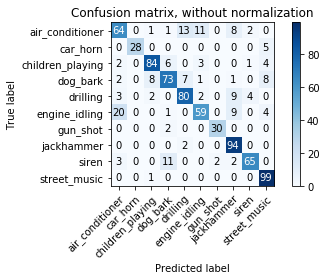

In [135]:
plot_confusion_matrix(labelled_test, labelled_predictions_3d, classes=my_list,
                      title='Confusion matrix, without normalization')

plt.savefig('confused.png')

In [140]:
final_model.save(r'D:\Machine_Learning\UrbanSound8K\UrbanSound8K\resnet_model\final_model.h5')